# Workday Data Science Test

In [1]:
# # NOTE: if there are any issues then install packages via pip

# Imports
import os
import openpyxl

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Seaborn theme
sns.set_theme(style="white")

In [2]:
# Data import
df = pd.read_excel("Data Science Assessment - Employee Data.xlsx", engine='openpyxl')

## 1 : Data Cleaning

EmployeeNumber was removed, no work done to test if first employees are less likely to be attrition but using the assumption that this is related to years spent with employer.

In [3]:
# Drop NaN columns
df = df.dropna(axis=1, how='all')

In [4]:
# Remove redundant cols - only one unique value for all employees
df.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1, inplace=True)

In [5]:
df.shape

(1470, 31)

In [6]:
# Data types
df_info = pd.DataFrame(df.dtypes,columns=['Data Type'])

# Unique values
df_info['Unique Values'] = df.nunique()

# NaN values
df_info['NaN Values']=df.isna().sum()

# Zero values
df_info['Zero Values'] = (df==0).sum()

df_info.sort_values(by='Unique Values', ascending=False)

,Data Type,Unique Values,NaN Values,Zero Values
MonthlyRate,int64,1427,0,0
MonthlyIncome,int64,1349,0,0
DailyRate,int64,886,0,0
HourlyRate,int64,71,0,0
Age,int64,43,0,0
TotalWorkingYears,int64,40,0,11
YearsAtCompany,int64,37,0,44
DistanceFromHome,int64,29,0,0
YearsInCurrentRole,int64,19,0,244
YearsWithCurrManager,int64,18,0,263


In [7]:
# Split features by encoding type
feature_cols = {
    'onehot': ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender'],
    'numerical': ['Age', 'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 
                  'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                  'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                  'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
                  'YearsSinceLastPromotion', 'YearsWithCurrManager', 'DistanceFromHome', 'Education', 
                  'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction'
                 ],
    'ordinal': ['BusinessTravel'],
    'boolean': ['Attrition', 'OverTime']
}

# Get numerical values (no encoding required)
df_clean = df[feature_cols['numerical']].copy()

In [8]:
# Ordinal encoding
mapper = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
df_clean['BusinessTravel'] = df['BusinessTravel'].map(mapper)

In [9]:
# Boolean encoding
for col in feature_cols['boolean']:
    df_clean[col] = df[col].replace({'Yes': 1, 'No': 0})

# Move Attrition to first col (target variable for classification later on)
att_col = df_clean.pop('Attrition')
df_clean.insert(0, 'Attrition', att_col)

In [10]:
# DataFrame for label encoding (used for plots)
df_label = df_clean.copy()

# One-hot encoding
one_hot = pd.get_dummies(df[feature_cols['onehot']])
df_onehot = df_clean.join(one_hot)

# Label encoding - would normally store encoder but ignoring for this task
for feature in feature_cols['onehot']:
    encoder = LabelEncoder()
    label = encoder.fit_transform(df[feature])
    df_label[feature] = label

In [11]:
print('Number of features w/ one-hot encoding:', df_onehot.shape[1])
print('Number of features w/ label encoding:', df_label.shape[1])

Number of features w/ one-hot encoding: 49
Number of features w/ label encoding: 31


## 2 : Data Statistics

In [12]:
attrition_rate = df_label['Attrition'].value_counts() / df_label.shape[0]
print('Number of Non-Attrition:', df_label['Attrition'].value_counts()[0])
print('Number of Attrition:', df_label['Attrition'].value_counts()[1])
print('Total Attrition (%): {:1.0%}'.format(attrition_rate[1]))

Number of Non-Attrition: 1233
Number of Attrition: 237
Total Attrition (%): 16%


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.00,19999.0


In [14]:
# Get mean values grouped by attrition
df.groupby('Attrition').mean().T

<ipython-input-14-4b510a4ecbd3>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Attrition').mean().T


Attrition,No,Yes
Age,37.561233,33.607595
DailyRate,812.504461,750.362869
DistanceFromHome,8.915653,10.632911
Education,2.927007,2.839662
EnvironmentSatisfaction,2.771290,2.464135
HourlyRate,65.952149,65.573840
JobInvolvement,2.770479,2.518987
JobLevel,2.145985,1.637131
JobSatisfaction,2.778589,2.468354
MonthlyIncome,6832.739659,4787.092827


## 3 : Plots

In [15]:
df_test = df_label.copy()

In [16]:
plot_cols = {
    'onehot': ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender'],
    'numerical': ['Age', 'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 
                  'NumCompaniesWorked', 'PercentSalaryHike',
                  'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 
                  'YearsSinceLastPromotion', 'YearsWithCurrManager', 'DistanceFromHome'
                 ],
    'ordinal': ['BusinessTravel', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
               'TrainingTimesLastYear', 'WorkLifeBalance', 'Education', 
                  'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'OverTime']
}

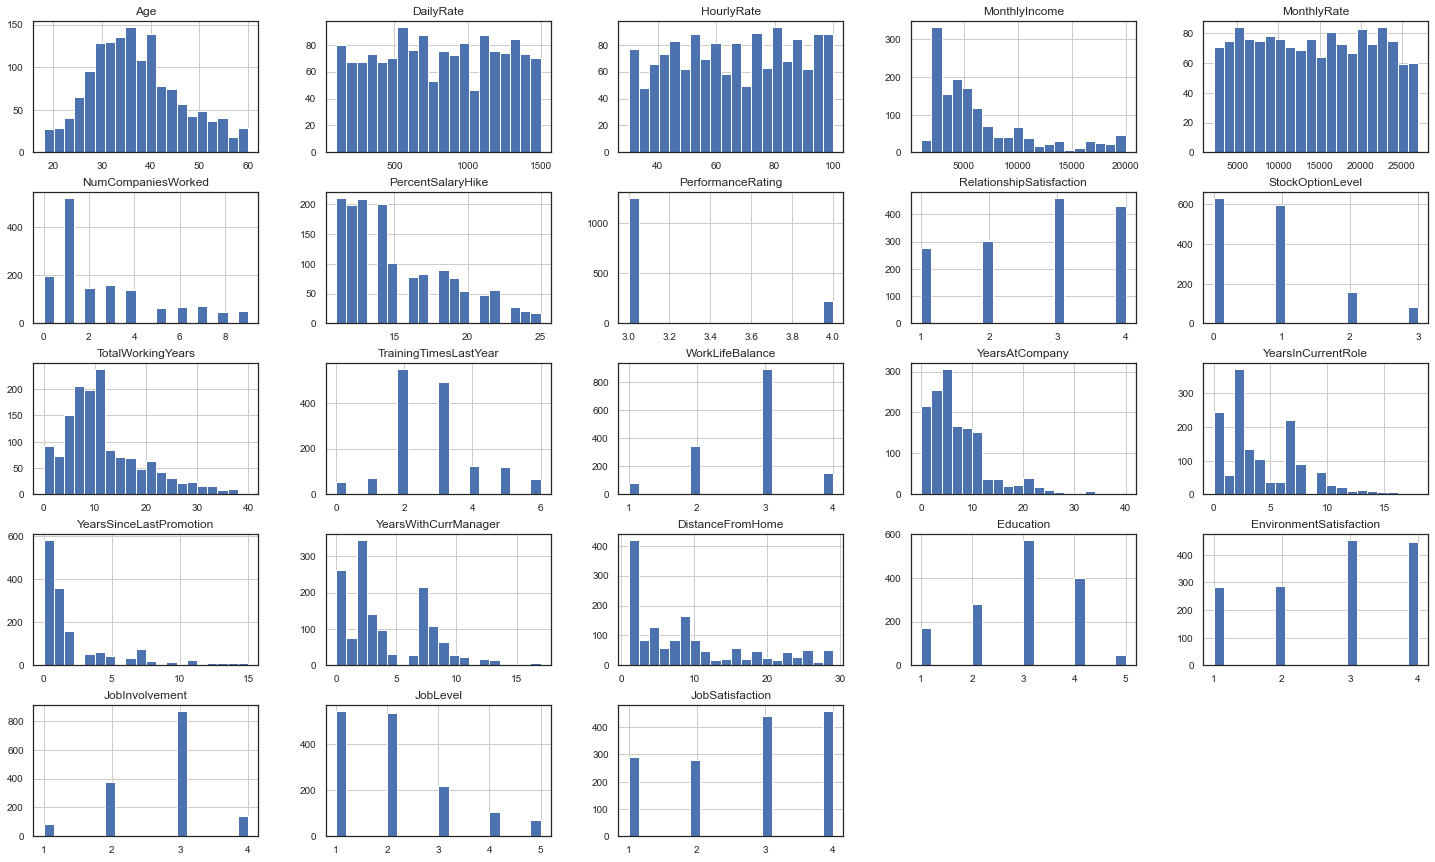

In [17]:
# Distribution plots
df_test[feature_cols['numerical']].hist(figsize=(25, 15), bins=20, xlabelsize=10, ylabelsize=10)
plt.show()

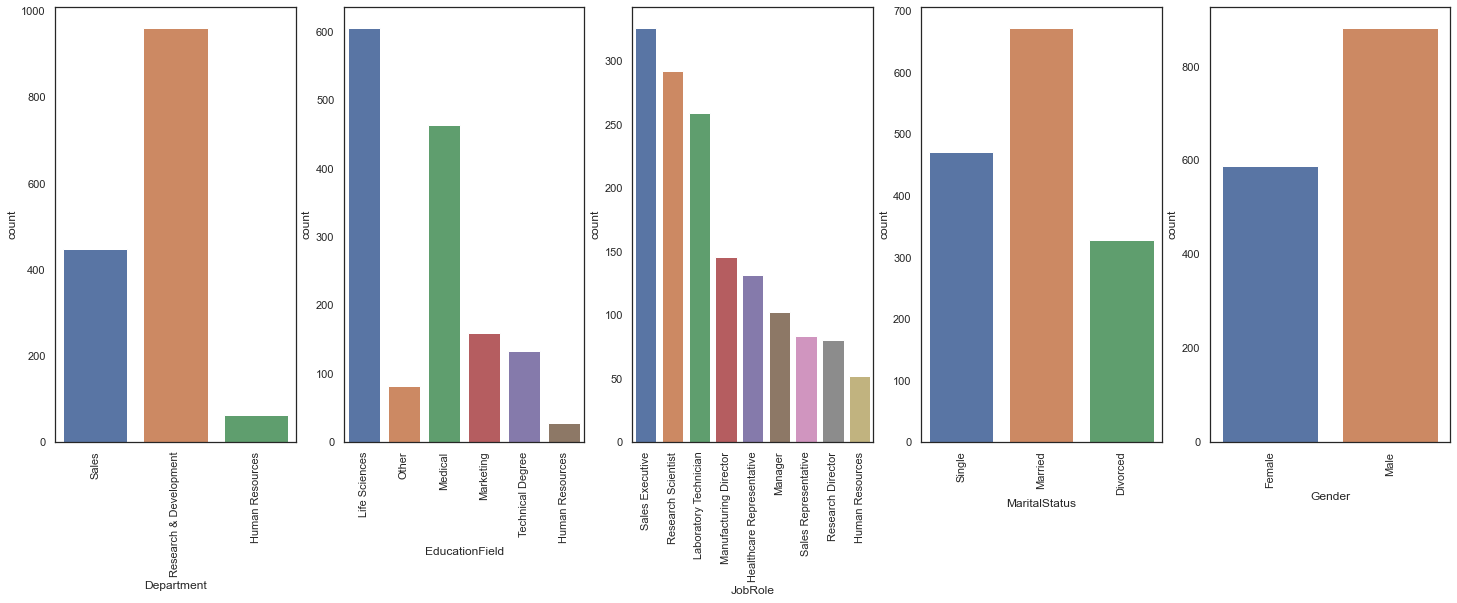

In [18]:
# Count plot for categorical data
fig, ax = plt.subplots(1, 5, figsize=(25, 8))
for feature, subplt in zip(feature_cols['onehot'], ax.flatten()):
    sns.countplot(data = df, x=feature, ax=subplt)
    for label in subplt.get_xticklabels():
        label.set_rotation(90)

In [19]:
def generate_plots(df, cols, target='Attrition', plot_type='histplot', kde=False):
    """
    Given a dataframe, generate histograms/boxplots of features (cols) separated by a target attribute.
    """
    
    # Calculate number of rows for figure
    n_cols = int(np.ceil(len(cols) / 2))
    
    # Generate plot
    fig, ax = plt.subplots(nrows=2,
                           ncols=n_cols, 
                           figsize=(25,10),
                           constrained_layout=True
                          )
    
    ax = ax.ravel()
    
    for i in range(len(cols)):
        if plot_type == 'boxplot':
            sns.boxplot(data=df, x=target, y=df[cols[i]], ax=ax[i])
        elif plot_type == 'histplot':
            sns.histplot(data=df, x=df[cols[i]], hue=target, ax=ax[i], bins=30, kde=kde)
#             if kde:
#                 plt.axvline(x=df[df[target]=='Yes'][cols[i]].mean())
#                 plt.axvline(x=df[df[target]=='No'][cols[i]].mean(), color='orange')
    
    return fig

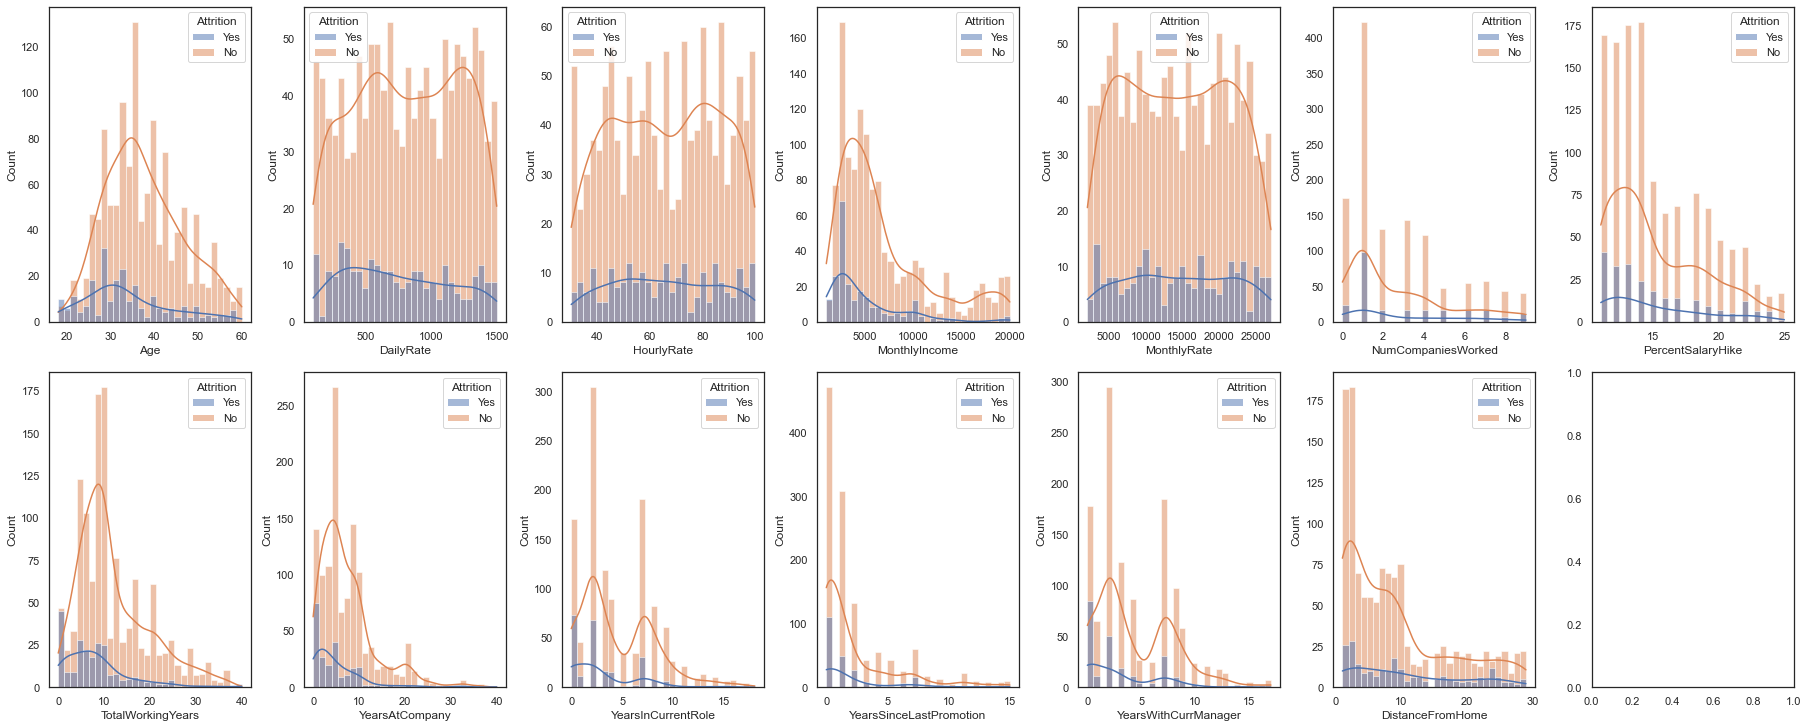

In [20]:
fig = generate_plots(df, plot_cols['numerical'], kde=True)
plt.show()

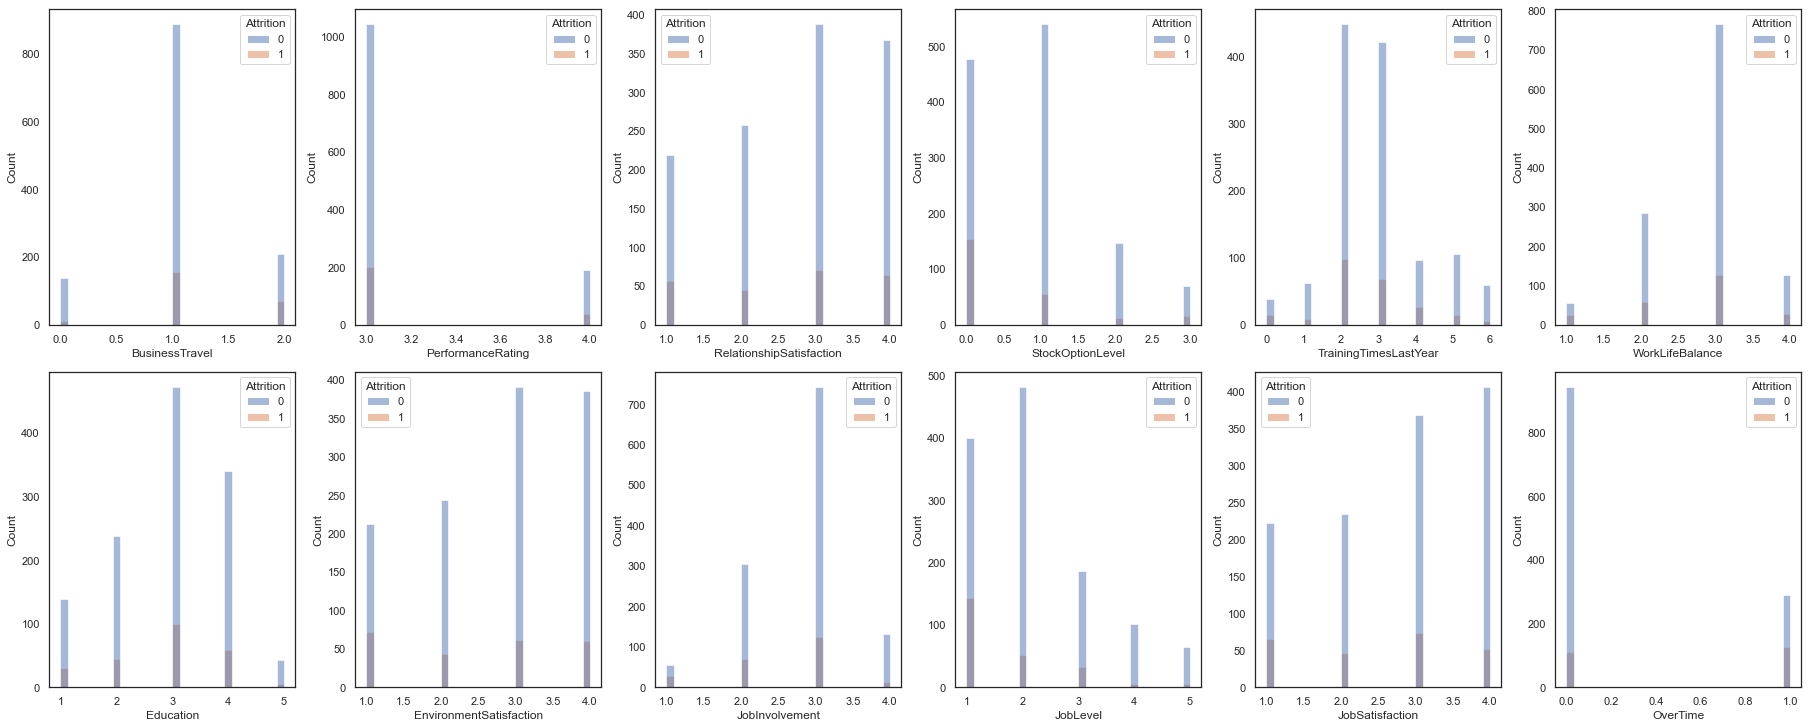

In [21]:
fig = generate_plots(df_clean, plot_cols['ordinal'], kde=False)
plt.show()

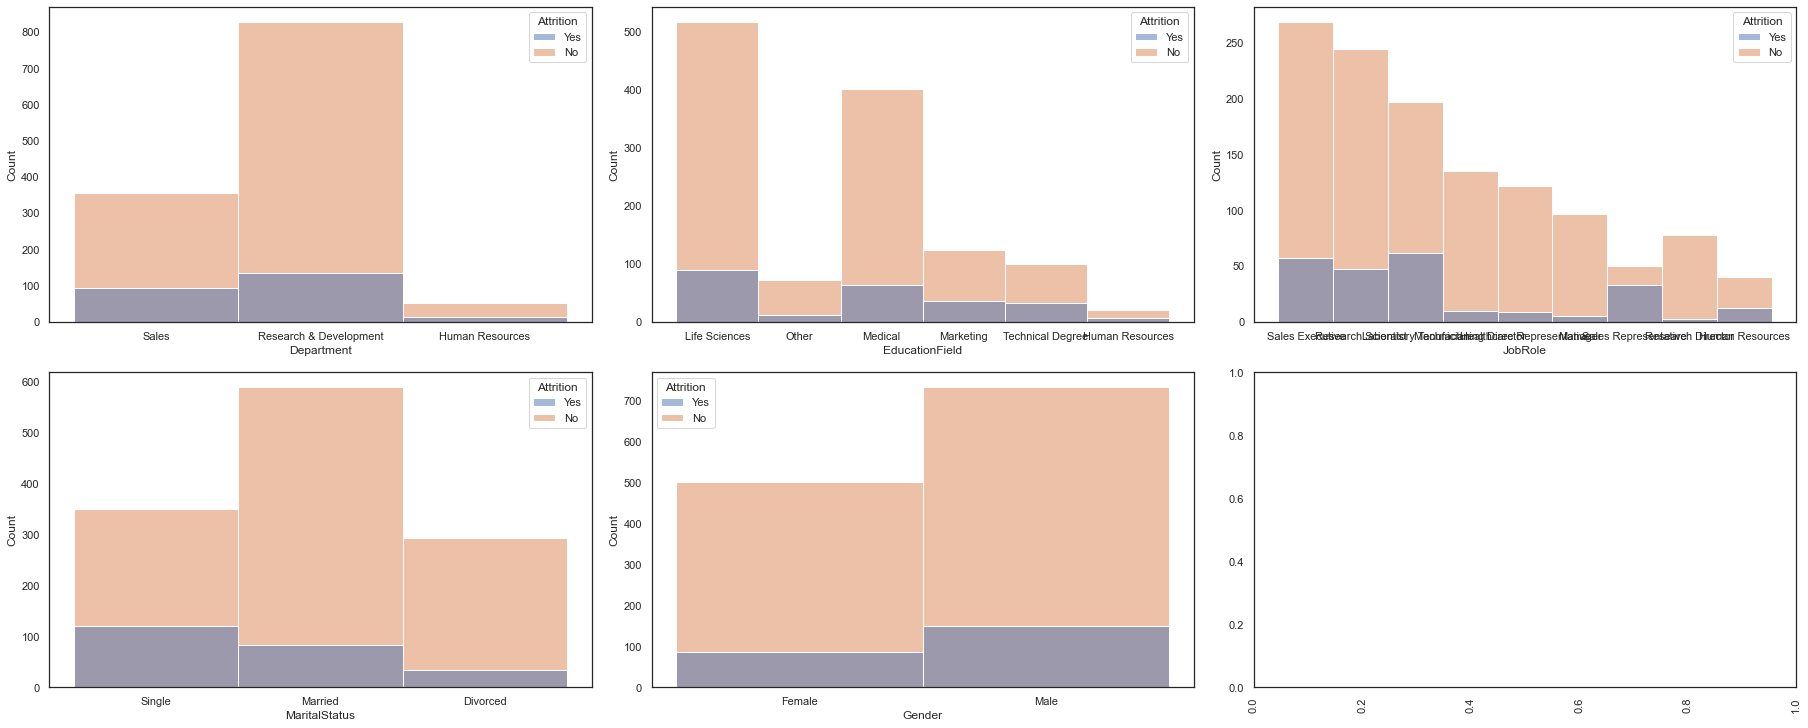

In [22]:
fig = generate_plots(df, plot_cols['onehot'], kde=False)
plt.xticks(rotation='vertical')
plt.show()

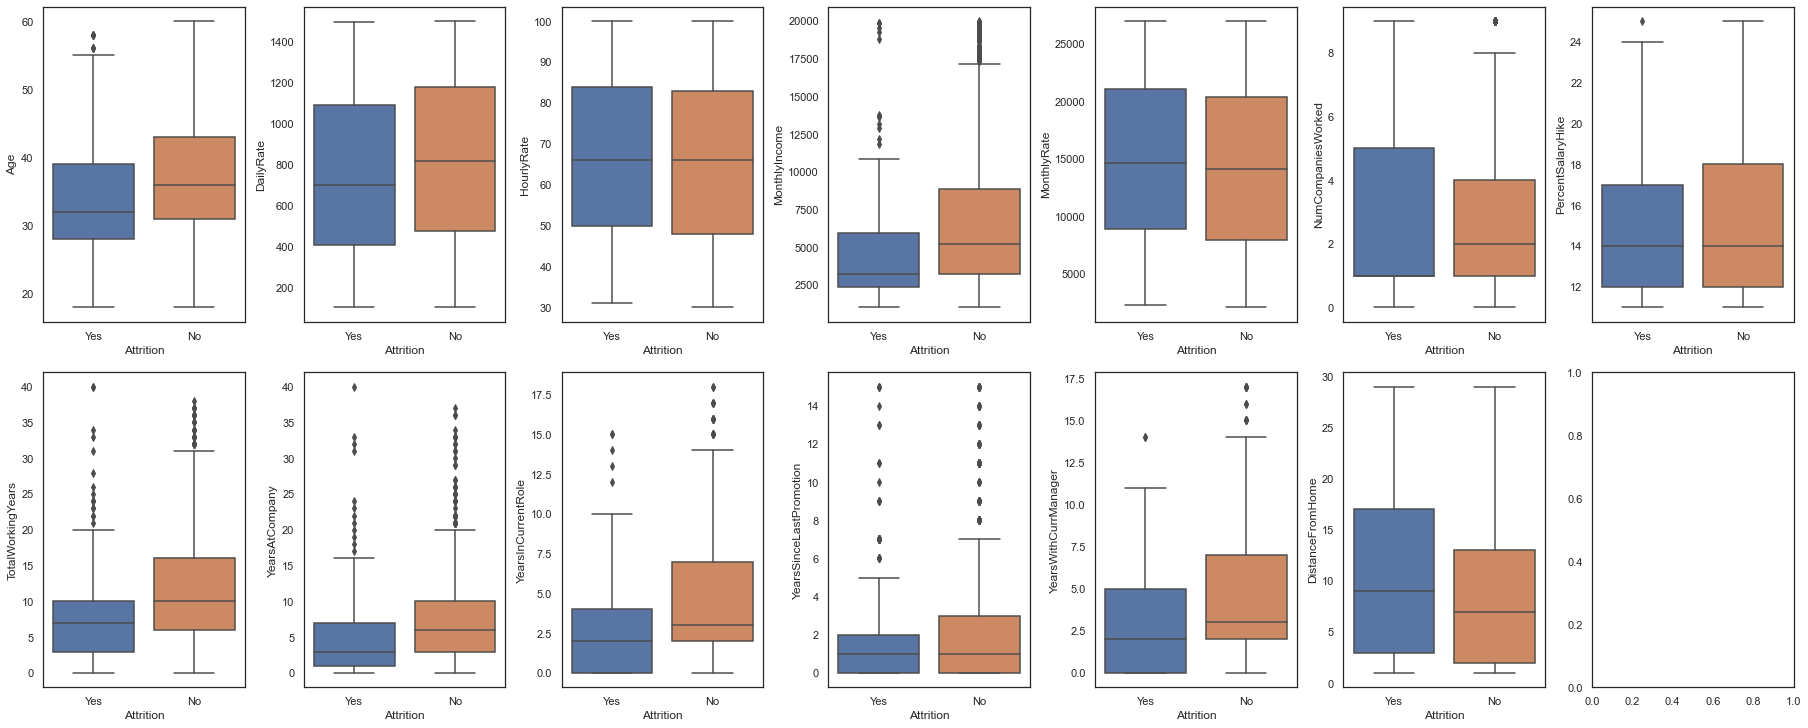

In [23]:
fig = generate_plots(df, plot_cols['numerical'], plot_type='boxplot')
plt.show()

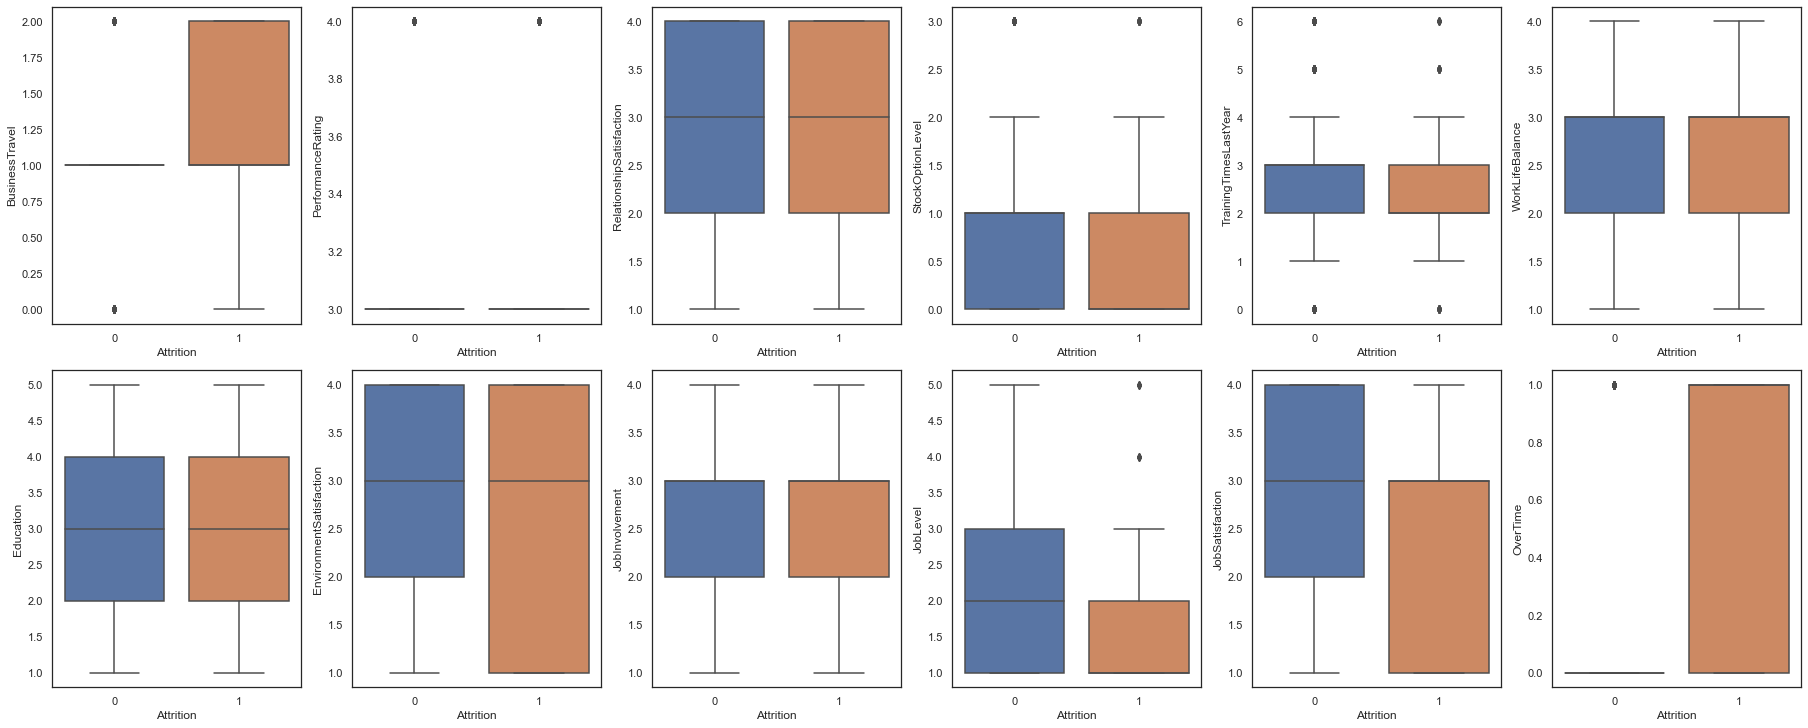

In [24]:
fig = generate_plots(df_test, plot_cols['ordinal'], plot_type='boxplot')
plt.show()

In [25]:
# Calculate WeightedSatisfaction
df_test['WeightedSatisfaction'] = (df_test['JobSatisfaction'] 
                                   + df_test['RelationshipSatisfaction']
                                   + df_test['EnvironmentSatisfaction']
                                  ) / 3

df['WeightedSatisfaction'] = (df['JobSatisfaction'] 
                              + df['RelationshipSatisfaction']
                              + df['EnvironmentSatisfaction']
                             ) / 3

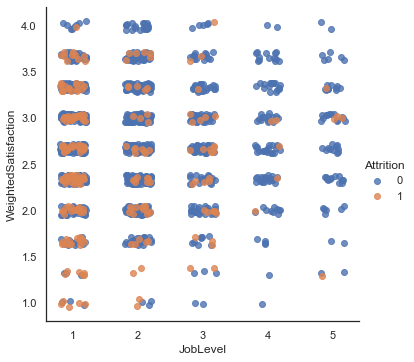

In [26]:
sns.lmplot(data=df_test, 
           x='JobLevel', 
           y='WeightedSatisfaction', 
           x_jitter=0.2, 
           y_jitter=0.05, 
           fit_reg=False, 
           hue='Attrition'
          )
plt.show()

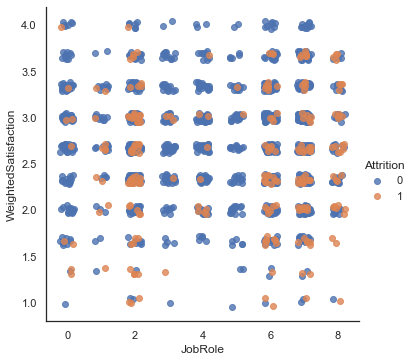

In [27]:
sns.lmplot(data=df_test, 
           x='JobRole', 
           y='WeightedSatisfaction', 
           x_jitter=0.2, 
           y_jitter=0.05,
           fit_reg=False, 
           hue='Attrition'
          )
plt.show()

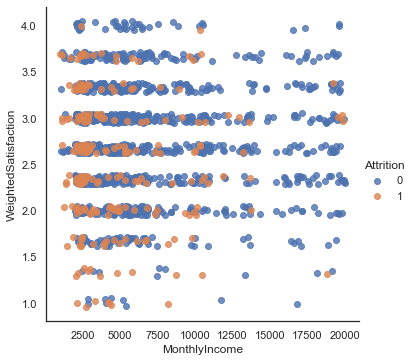

In [28]:
sns.lmplot(data=df_test, 
           x='MonthlyIncome', 
           y='WeightedSatisfaction', 
           y_jitter=0.05,
           fit_reg=False, 
           hue='Attrition'
          )
plt.show()

### 3.1 : Correlation Plots

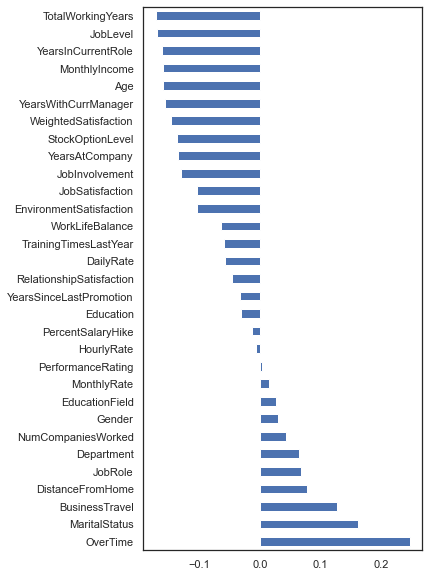

In [29]:
# Get ordered correlation between features and Attrition (target)
df_test.drop("Attrition", axis=1).apply(lambda x: x.corr(df_test.Attrition)).sort_values(ascending=False).plot(kind='barh', figsize=(5, 10))
plt.show()

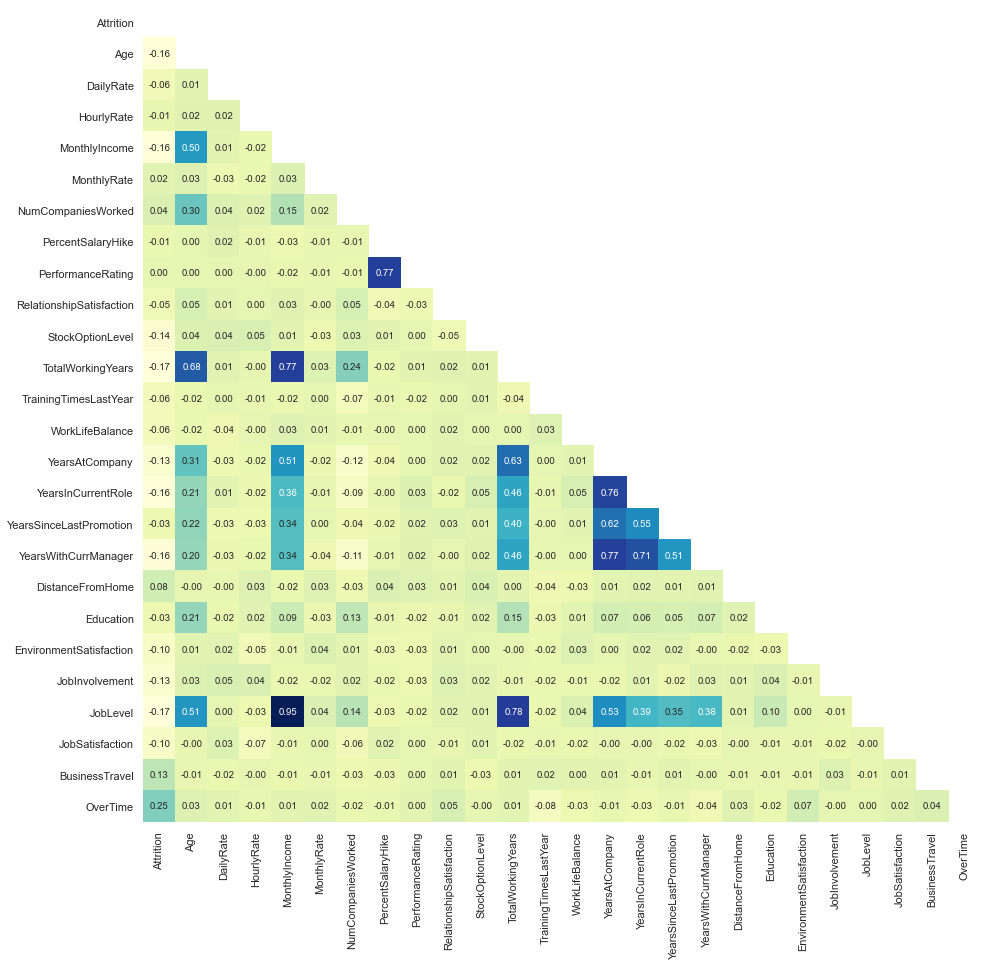

In [30]:
# Correlation plot - numerical features
plt.figure(figsize=(15,15))
corr = df_clean.corr()
# Mask upper triangle for visual clarity
mat = np.triu(corr)

hmap = sns.heatmap(corr,
                   mask=mat,
                   annot=True,
                   annot_kws={"size": 250/len(corr)},
                   fmt='.2f',
                   cbar=False,
                   cmap='YlGnBu'
                  )
plt.show()

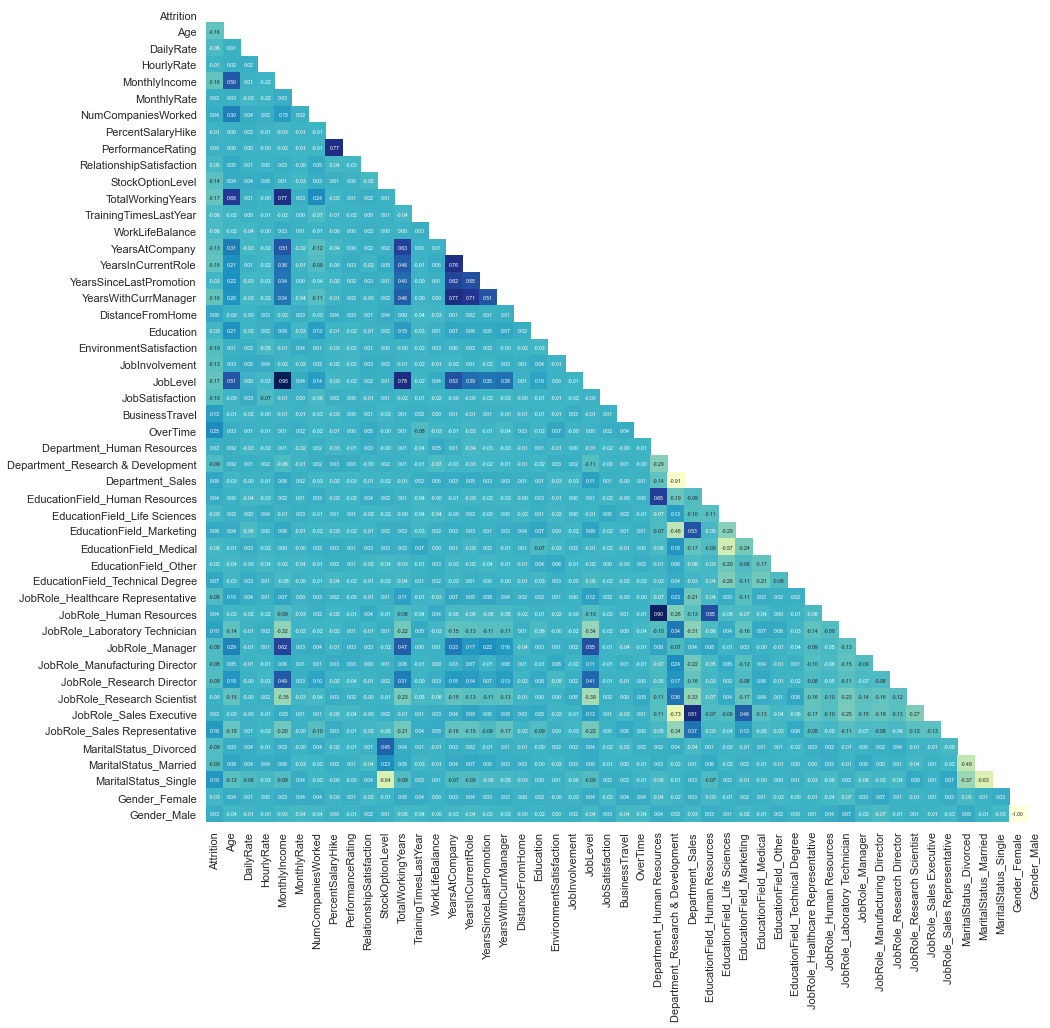

In [31]:
# Correlation plot - all features (onehot)
plt.figure(figsize=(15,15))
corr = df_onehot.corr()
# Mask upper triangle for visual clarity
mat = np.triu(corr)

hmap = sns.heatmap(corr,
                   mask=mat,
                   annot=True,
                   annot_kws={"size": 250/len(corr)},
                   fmt='.2f',
                   cbar=False,
                   cmap='YlGnBu'
                  )
plt.show()

In [32]:
# # NOTE: takes a long time to run
# sns.pairplot(df_clean, hue='Attrition')

## 4 : Significance Tests

In [33]:
# Calculate mean value per attrition type
mean_attri = df['JobSatisfaction'][df['Attrition']=='Yes'].mean()
mean_activ = df['JobSatisfaction'][df['Attrition']=='No'].mean()
print('Average JobSatisfaction (Ex-Employee): {:.2f}'.format(mean_attri))
print('Average JobSatisfaction (Current Employee): {:.2f}'.format(mean_activ))

Average JobSatisfaction (Ex-Employee): 2.47
Average JobSatisfaction (Current Employee): 2.78


We can see from the above results that the mean value for JobSatisfaction is lower for ex-employees.

Setting this up as a hypothesis test lets assume the following:
- $\text{H}_0$: The average JobSatisfaction is equivalent for both ex- and current employees ($\mu_{\text{Active}}=\mu_{\text{Attri}}$)
- $\text{H}_1$: The average JobSatisfaction is *different* for ex-employees vs current employees
    - Lets assume we have no intuitive reason to believe it is better or worse

In [34]:
t_stat, p_value = stats.ttest_1samp(a=df['JobSatisfaction'][df['Attrition']=='Yes'], popmean=mean_activ)
print('p_value:', p_value)

p_value: 2.814281106863117e-05


Doing a one-sample t-test* for these values, you can see that we return a p-value signifiantly lower than standard for hypothesis testing (0.05), therefore rejecting our null hypothesis (the difference in JobSatisfaction between the two groups is statistically significant - although with this test we have not defined direction)

Similar tests could be done for other Satisfaction survey results

*t-test chosen due to large sample size + CLT means sample distribution would approximate a normal distribution

## 5 : Classification

### 5.1 : Data Split

In [35]:
def get_split_data(df):
    """
    Get train/test split given a DataFrame.
    
    Note: Assumes target variable at location df.iloc[:, 0].
    """
    
    # Stratify for train/test split due to imbalanced Attrition in dataset
    x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:]
                                                        , df.iloc[:, 0]
                                                        , test_size=0.3
                                                        , random_state=0
                                                        , stratify=df.iloc[:, 0]
                                                       )
    
    return x_train, x_test, y_train, y_test

In [36]:
x_train_oh, x_test_oh, y_train_oh, y_test_oh = get_split_data(df_onehot)
x_train_lb, x_test_lb, y_train_lb, y_test_lb = get_split_data(df_label)

### 5.2 : Baseline Performance

In [37]:
def plot_roc_curve(fpr, tpr):
    """
    Given a fpr and tpr, return a ROC curve plot.
    """
    
    # Plot curve
    plt.plot(fpr, tpr, linewidth=2)
    # Plot baseline performance
    plt.plot([0, 1], [0, 1])
    # Define axis boundaries
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    return plt

In [38]:
def evaluate_model(model, x_train, x_test, y_train, y_test):
    """
    Given a model and train/test datasets, get train/test predictions
    and return key evaluation metrics of performance.
    """
    
    # Get train predictions/accuracy
    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    
    # Get test predictions/accuracy
    y_pred = model.predict(x_test)
    test_accuracy = accuracy_score(y_test, y_pred) * 100
    
    # Get classification report
    clf_report = classification_report(y_test, y_pred)
    
    # Get confusion matrix plot
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    cf_matrix_fig = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    roc_curve_fig = plot_roc_curve(fpr, tpr)
    plt.show()
    
    return train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig

#### 5.21 : Logistic Regression

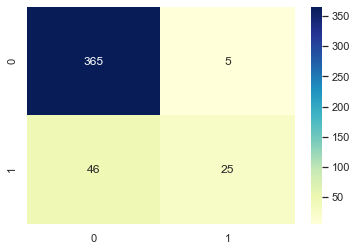

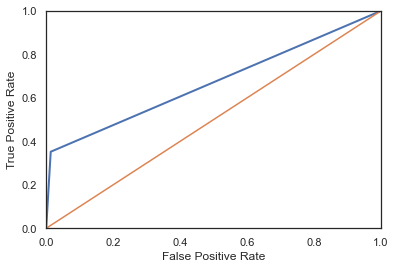

Train Accuracy: 89.12%
Test Accuracy: 88.44%
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       370
           1       0.83      0.35      0.50        71

    accuracy                           0.88       441
   macro avg       0.86      0.67      0.71       441
weighted avg       0.88      0.88      0.86       441



In [39]:
# One-hot encoding
lr_clf = LogisticRegression(solver='liblinear', penalty='l1').fit(x_train_oh, y_train_oh)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(lr_clf
                                                                                         , x_train_oh
                                                                                         , x_test_oh
                                                                                         , y_train_oh
                                                                                         , y_test_oh
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

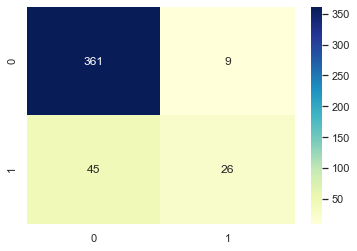

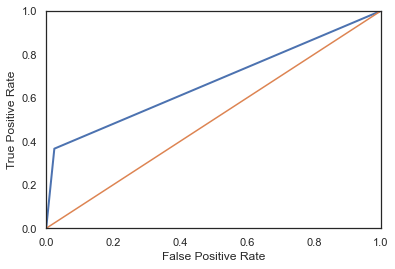

Train Accuracy: 88.14%
Test Accuracy: 87.76%
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       370
           1       0.74      0.37      0.49        71

    accuracy                           0.88       441
   macro avg       0.82      0.67      0.71       441
weighted avg       0.87      0.88      0.86       441



In [40]:
# Label encoding
lr_clf = LogisticRegression(solver='liblinear', penalty='l1').fit(x_train_lb, y_train_lb)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(lr_clf
                                                                                         , x_train_lb
                                                                                         , x_test_lb
                                                                                         , y_train_lb
                                                                                         , y_test_lb
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

#### 5.22 : Random Forest

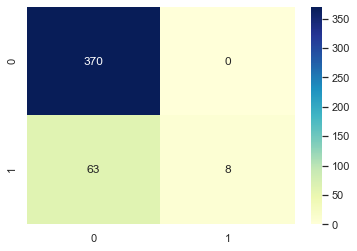

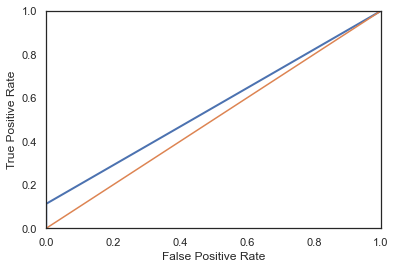

Train Accuracy: 90.67%
Test Accuracy: 85.71%
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       370
           1       1.00      0.11      0.20        71

    accuracy                           0.86       441
   macro avg       0.93      0.56      0.56       441
weighted avg       0.88      0.86      0.81       441



In [41]:
# One-hot encoding
rf_clf = RandomForestClassifier(n_estimators=100
                                , max_depth=20
                                , min_samples_split=10
                                , min_samples_leaf=3
                               ).fit(x_train_oh, y_train_oh)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_oh
                                                                                         , x_test_oh
                                                                                         , y_train_oh
                                                                                         , y_test_oh
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

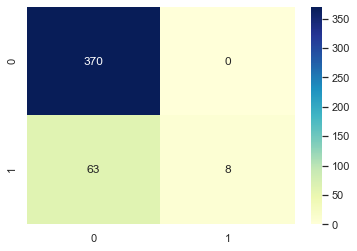

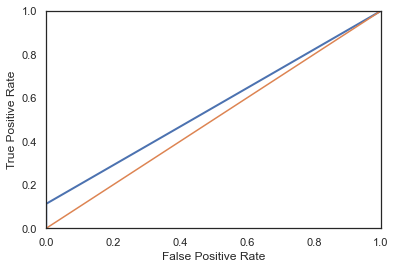

Train Accuracy: 91.35%
Test Accuracy: 85.71%
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       370
           1       1.00      0.11      0.20        71

    accuracy                           0.86       441
   macro avg       0.93      0.56      0.56       441
weighted avg       0.88      0.86      0.81       441



In [42]:
# Label encoding
rf_clf = RandomForestClassifier(n_estimators=100
                                , max_depth=20
                                , min_samples_split=10
                                , min_samples_leaf=3
                               ).fit(x_train_lb, y_train_lb)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_lb
                                                                                         , x_test_lb
                                                                                         , y_train_lb
                                                                                         , y_test_lb
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

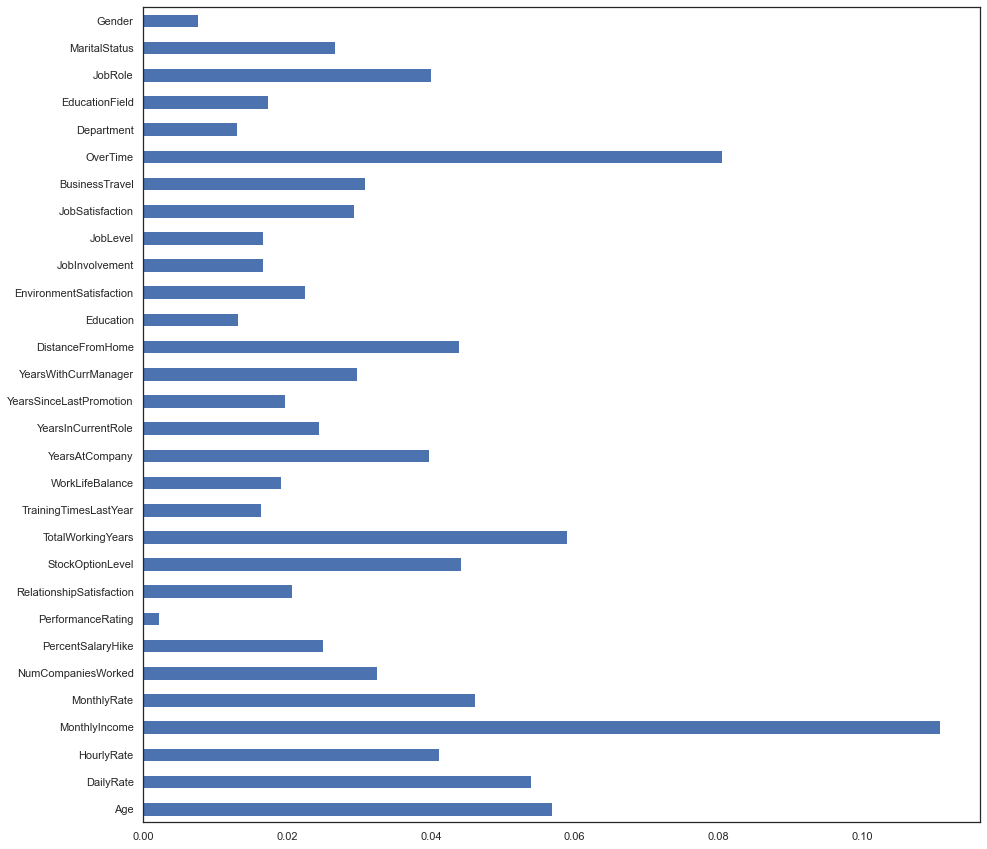

In [43]:
importance = pd.Series(rf_clf.feature_importances_, index=x_train_lb.columns)

plt.figure(figsize=(15, 15))
importance.plot(kind='barh')
plt.show()

### 5.3 : Sampling

#### 5.31 : Oversampling

In [44]:
smote = SMOTE(random_state=0)
x_train_lb_smote, y_train_lb_smote= smote.fit_resample(x_train_lb, y_train_lb)

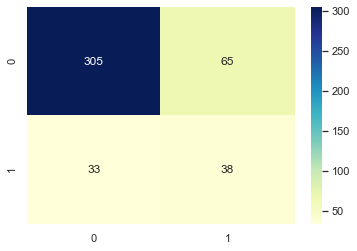

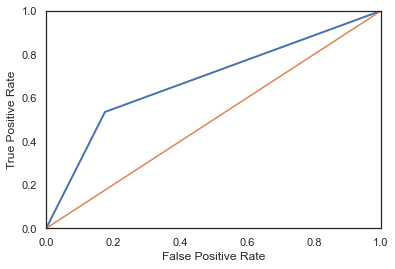

Train Accuracy: 83.02%
Test Accuracy: 77.78%
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       370
           1       0.37      0.54      0.44        71

    accuracy                           0.78       441
   macro avg       0.64      0.68      0.65       441
weighted avg       0.82      0.78      0.79       441



In [45]:
# Label encoding
lr_clf = LogisticRegression(solver='liblinear', penalty='l1').fit(x_train_lb_smote, y_train_lb_smote)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(lr_clf
                                                                                         , x_train_lb_smote
                                                                                         , x_test_lb
                                                                                         , y_train_lb_smote
                                                                                         , y_test_lb
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

#### 5.32 : Undersampling

In [46]:
nm = NearMiss(version=3, n_neighbors_ver3=3)
x_train_lb_nm, y_train_lb_nm = nm.fit_resample(x_train_lb, y_train_lb)

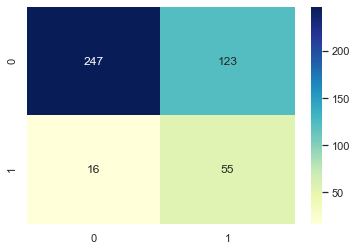

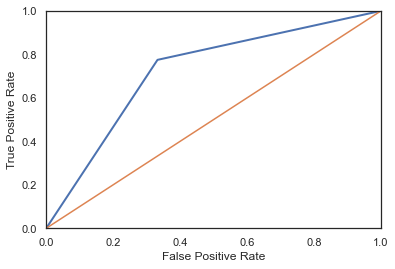

Train Accuracy: 83.73%
Test Accuracy: 68.48%
              precision    recall  f1-score   support

           0       0.94      0.67      0.78       370
           1       0.31      0.77      0.44        71

    accuracy                           0.68       441
   macro avg       0.62      0.72      0.61       441
weighted avg       0.84      0.68      0.73       441



In [47]:
# Label encoding
lr_clf = LogisticRegression(solver='liblinear', penalty='l1').fit(x_train_lb_nm, y_train_lb_nm)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(lr_clf
                                                                                         , x_train_lb_nm
                                                                                         , x_test_lb
                                                                                         , y_train_lb_nm
                                                                                         , y_test_lb
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

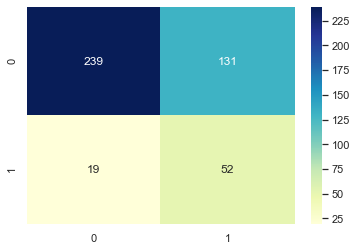

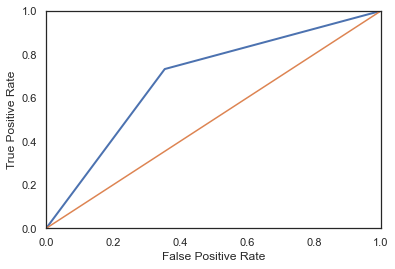

Train Accuracy: 93.07%
Test Accuracy: 65.99%
              precision    recall  f1-score   support

           0       0.93      0.65      0.76       370
           1       0.28      0.73      0.41        71

    accuracy                           0.66       441
   macro avg       0.61      0.69      0.59       441
weighted avg       0.82      0.66      0.70       441



In [48]:
# Label encoding
rf_clf = RandomForestClassifier(n_estimators=100
                                , max_depth=20
                                , min_samples_split=10
                                , min_samples_leaf=3
                               ).fit(x_train_lb_nm, y_train_lb_nm)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_lb_nm
                                                                                         , x_test_lb
                                                                                         , y_train_lb_nm
                                                                                         , y_test_lb
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

### 5.4 : Feature Scaling

#### 5.41 : Log Scaling

/Users/elliottloveridge/Environments/venv/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/elliottloveridge/Environments/venv/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


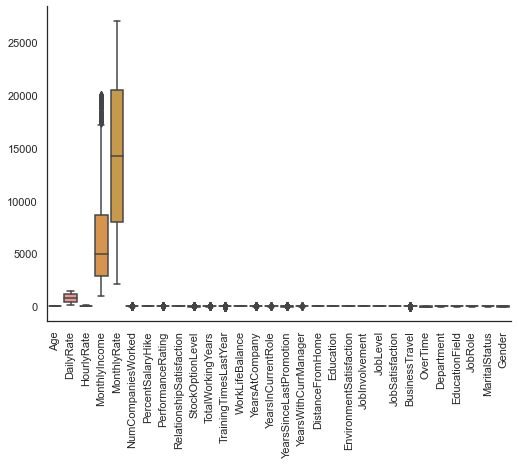

In [49]:
# Features before scaling
sns.catplot(data=x_train_lb, kind='box', aspect=1.5)
plt.xticks(rotation=90)
plt.show()

In [50]:
# Create DataFrame copies
x_train_lb_log = x_train_lb.copy()
y_train_lb_log = y_train_lb.copy()

x_test_lb_log = x_test_lb.copy()
y_test_lb_log = y_test_lb.copy()

# Apply log transform to MonthlyIncome and MonthlyRate
x_train_lb_log['MonthlyIncome'] = np.log(x_train_lb_log['MonthlyIncome'])
x_train_lb_log['MonthlyRate'] = np.log(x_train_lb_log['MonthlyRate'])

x_test_lb_log['MonthlyIncome'] = np.log(x_test_lb_log['MonthlyIncome'])
x_test_lb_log['MonthlyRate'] = np.log(x_test_lb_log['MonthlyRate'])

/Users/elliottloveridge/Environments/venv/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/elliottloveridge/Environments/venv/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


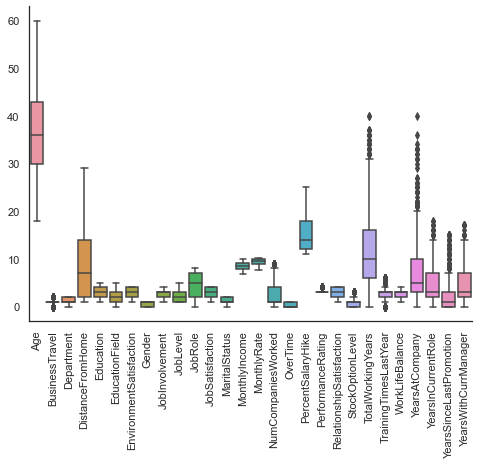

In [51]:
# Features after log scaling - excluded DailyRate/HourlyRate as not suitable for log scaling but remains skewed
# # NOTE: given more time, could apply other standardisation techniques
tmp = x_train_lb_log.loc[:, x_train_lb_log.columns.difference(['DailyRate', 'HourlyRate'])]
sns.catplot(data=tmp, kind='box', aspect=1.5)
plt.xticks(rotation=90)
plt.show()

In [52]:
x_train_lb_log_nm, y_train_lb_log_nm = nm.fit_resample(x_train_lb_log, y_train_lb_log)

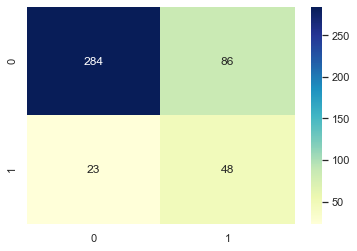

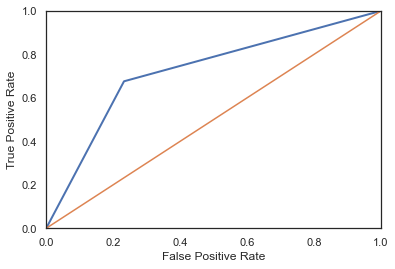

Train Accuracy: 96.99%
Test Accuracy: 75.28%
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       370
           1       0.36      0.68      0.47        71

    accuracy                           0.75       441
   macro avg       0.64      0.72      0.65       441
weighted avg       0.83      0.75      0.78       441



In [53]:
# Label encoding
rf_clf = RandomForestClassifier(n_estimators=100
                                , max_depth=20
                                , min_samples_split=10
                                , min_samples_leaf=3
                               ).fit(x_train_lb_log_nm, y_train_lb_log_nm)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_lb_log_nm
                                                                                         , x_test_lb_log
                                                                                         , y_train_lb_log_nm
                                                                                         , y_test_lb_log
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

#### 5.42 : Standard Scaling

In [54]:
sc = StandardScaler()

# Create DataFrame copies
x_train_lb_sc = x_train_lb.copy()
y_train_lb_sc = y_train_lb.copy()

x_test_lb_sc = x_test_lb.copy()
y_test_lb_sc = y_test_lb.copy()

x_train_lb_sc = sc.fit_transform(x_train_lb_sc)
x_test_lb_sc = sc.transform(x_test_lb_sc)

In [55]:
x_train_lb_sc_nm, y_train_lb_sc_nm = nm.fit_resample(x_train_lb_sc, y_train_lb_sc)

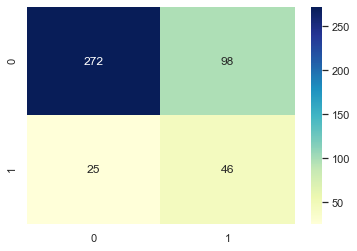

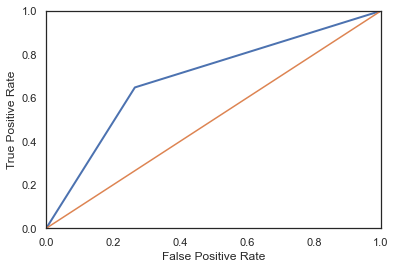

Train Accuracy: 96.08%
Test Accuracy: 72.11%
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       370
           1       0.32      0.65      0.43        71

    accuracy                           0.72       441
   macro avg       0.62      0.69      0.62       441
weighted avg       0.82      0.72      0.75       441



In [56]:
# Label encoding
rf_clf = RandomForestClassifier(n_estimators=100
                                , max_depth=20
                                , min_samples_split=10
                                , min_samples_leaf=3
                               ).fit(x_train_lb_sc_nm, y_train_lb_sc_nm)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_lb_sc_nm
                                                                                         , x_test_lb_sc
                                                                                         , y_train_lb_sc_nm
                                                                                         , y_test_lb_sc
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

### 5.5 : Parameter Optimisation

In [57]:
n_estimators = [int(x) for x in np.linspace(start=40, stop=100, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=0)

rf_cv = RandomizedSearchCV(estimator=rf_clf
                           , scoring='f1'
                           , param_distributions=random_grid
                           , n_iter=20
                           , cv=3
                           , verbose=2
                           , random_state=0
                           , n_jobs=-1
                          )

rf_cv.fit(x_train_lb_log_nm, y_train_lb_log_nm)
rf_best_params = rf_cv.best_params_

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train_lb_log_nm, y_train_lb_log_nm)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomForestClassifier(max_depth=80, min_samples_split=10, n_estimators=93)

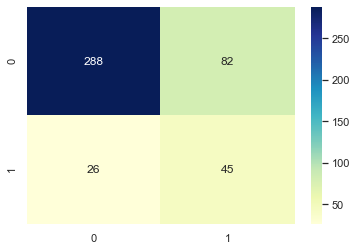

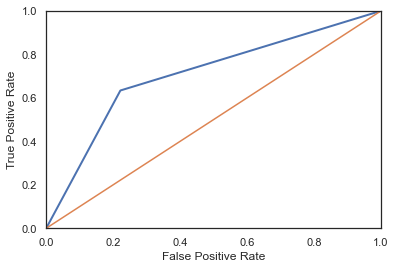

Train Accuracy: 97.89%
Test Accuracy: 75.51%
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       370
           1       0.35      0.63      0.45        71

    accuracy                           0.76       441
   macro avg       0.64      0.71      0.65       441
weighted avg       0.83      0.76      0.78       441



In [58]:
train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_lb_log_nm
                                                                                         , x_test_lb_log
                                                                                         , y_train_lb_log_nm
                                                                                         , y_test_lb_log
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)

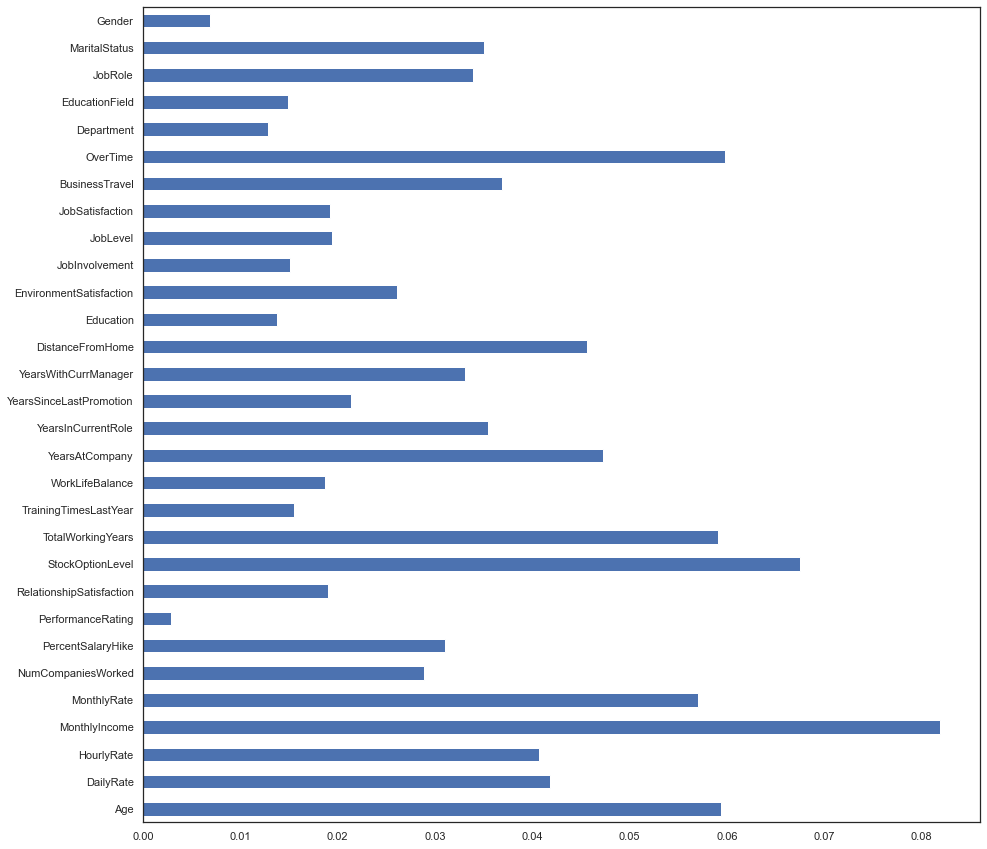

In [59]:
importance = pd.Series(rf_clf.feature_importances_, index=x_train_lb_log_nm.columns)

plt.figure(figsize=(15, 15))
importance.plot(kind='barh')
plt.show()

In [60]:
# sns.histplot(data=df, x='Age', hue='Attrition', bins=30, kde=True)
# plt.axvline(x=df[df['Attrition']=='Yes']['Age'].mean())
# plt.axvline(x=df[df['Attrition']=='No']['Age'].mean(), color='orange')
# plt.show()

In [61]:
# sns.histplot(data=df, x='PerformanceRating', hue='Attrition', bins=30)
# plt.xticks(rotation='vertical')
# plt.show()

In [62]:
# sns.boxplot(data=df, x='Attrition', y='Age')
# plt.show()

### 5.6 : Feature Reduction

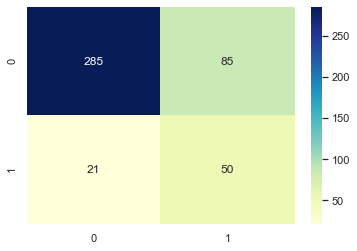

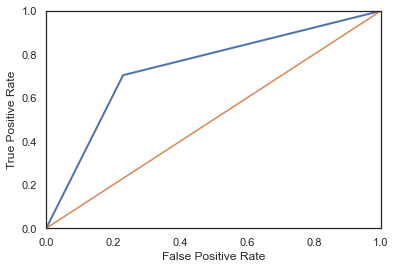

Train Accuracy: 94.28%
Test Accuracy: 75.96%
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       370
           1       0.37      0.70      0.49        71

    accuracy                           0.76       441
   macro avg       0.65      0.74      0.66       441
weighted avg       0.84      0.76      0.79       441



In [63]:
# Train using only highly correlated features (from previous analysis)
features = [
    'OverTime'
    , 'MaritalStatus'
    , 'BusinessTravel'
    , 'EnvironmentSatisfaction'
    , 'JobSatisfaction'
    , 'JobInvolvement'
    , 'YearsAtCompany'
    , 'StockOptionLevel'
    , 'YearsWithCurrManager'
    , 'Age'
    , 'MonthlyIncome'
    , 'YearsInCurrentRole'
    , 'JobLevel'
    , 'TotalWorkingYears']

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train_lb_log_nm[features], y_train_lb_log_nm)

train_accuracy, test_accuracy, clf_report, cf_matrix_fig, roc_curve_fig = evaluate_model(rf_clf
                                                                                         , x_train_lb_log_nm[features]
                                                                                         , x_test_lb_log[features]
                                                                                         , y_train_lb_log_nm
                                                                                         , y_test_lb_log
                                                                                        )

print('Train Accuracy: %.2f%%' % train_accuracy)
print('Test Accuracy: %.2f%%' % test_accuracy)
print(clf_report)